<a href="https://colab.research.google.com/github/iz-120/ECM514-Projeto02-Assistente-Diagnostico/blob/main/Projeto_2__Assistente_de_Diagn%C3%B3stico_de_Dengue_Principal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Principal

Aqui será desenvolvido o projeto e contempla as seguintes etapas:

1. Completar

# Inicialização

## Importações

In [17]:
import pandas as pd
import numpy as np
import requests
import zipfile
import os
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

## Funções

In [2]:
# ==============================================================================
# CARREGA OS DADOS UTILIZADOS
# ==============================================================================
def carregar_dados_dengue_de_release(url_release: str, ficheiro_csv_no_zip: str) -> pd.DataFrame:
    """
    Descarrega um ficheiro ZIP de uma URL, extrai um CSV específico e o carrega para um DataFrame.

    Args:
        url_release (str): O URL público para o ficheiro .zip na Release do GitHub.
        ficheiro_csv_no_zip (str): O nome exato do ficheiro .csv dentro do .zip.

    Returns:
        pd.DataFrame: Um DataFrame do Pandas contendo os dados do CSV, ou um DataFrame vazio em caso de erro.
    """
    print(f"A descarregar dados de: {url_release}")

    try:
        # Faz o request para obter o conteúdo do ficheiro
        response = requests.get(url_release, timeout=300) # Timeout de 5 minutos
        response.raise_for_status()  # Lança um erro para respostas HTTP > 400

        print("Download concluído com sucesso. A extrair o ficheiro CSV...")

        # Usa BytesIO para tratar o conteúdo do ZIP em memória, sem salvar no disco
        with zipfile.ZipFile(BytesIO(response.content)) as z:
            # Verifica se o ficheiro CSV esperado está no ZIP
            if ficheiro_csv_no_zip not in z.namelist():
                print(f"ERRO: O ficheiro '{ficheiro_csv_no_zip}' não foi encontrado no ZIP.")
                print(f"Ficheiros disponíveis: {z.namelist()}")
                return pd.DataFrame()

            # Extrai e carrega o CSV para o pandas
            with z.open(ficheiro_csv_no_zip) as f:
                df = pd.read_csv(f, low_memory=False)
                print(f"DataFrame carregado com sucesso! Shape: {df.shape}")
                return df

    except requests.exceptions.RequestException as e:
        print(f"ERRO: Falha ao descarregar o ficheiro. Motivo: {e}")
        return pd.DataFrame()
    except zipfile.BadZipFile:
        print("ERRO: O ficheiro descarregado não é um ZIP válido.")
        return pd.DataFrame()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        return pd.DataFrame()

## Recuperar dados


In [3]:
# URL dos dados a serem recuperados
URL_DADOS_BRUTOS = "https://github.com/iz-120/ECM514-Projeto02-Assistente-Diagnostico/releases/download/v1.0-dados/dengue_2025.zip"
URL_DADOS_LIMPOS = "https://github.com/iz-120/ECM514-Projeto02-Assistente-Diagnostico/releases/download/v1.0-dados/dengue_limpo_2025.zip"

# Nome exato do arquivo CSV dentro do seu arquivo .zip
CSV_BRUTO = "dengue_2025.csv"
CSV_LIMPO = "dengue_limpo_2025.csv"

# Chama a função para carregar os dados brutos - Não será utilizada
# df_bruto = carregar_dados_dengue_de_release(
#     url_release=URL_DADOS_BRUTOS,
#     ficheiro_csv_no_zip=CSV_BRUTO
# )

# Chama a função para carregar os dados limpos
df_dengue = carregar_dados_dengue_de_release(
    url_release=URL_DADOS_LIMPOS,
    ficheiro_csv_no_zip=CSV_LIMPO
)
df_dengue = df_dengue.dropna()

# Mostra as primeiras linhas do DataFrame se ele for carregado com sucesso
if not df_dengue.empty:
    print("\nAmostra dos dados carregados:")
    display(df_dengue.head())

A descarregar dados de: https://github.com/iz-120/ECM514-Projeto02-Assistente-Diagnostico/releases/download/v1.0-dados/dengue_limpo_2025.zip
Download concluído com sucesso. A extrair o ficheiro CSV...
DataFrame carregado com sucesso! Shape: (1516068, 20)

Amostra dos dados carregados:


,DT_NOTIFIC,IDADE_ANOS,DIAS_COM_SINTOMAS,RISCO_GRAVIDADE_grave,CS_SEXO_F,CS_SEXO_I,CS_RACA_Amarela,CS_RACA_Branca,CS_RACA_Indigena,CS_RACA_Parda,CS_RACA_Preta,FEBRE_sim,MIALGIA_sim,CEFALEIA_sim,EXANTEMA_sim,VOMITO_sim,NAUSEA_sim,PETEQUIA_N_sim,ARTRALGIA_sim,DOR_RETRO_sim
0,2025-04-22,33.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,2025-04-15,62.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-04-03,24.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
3,2025-04-15,7.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2025-04-30,19.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Modelagem e Treinamento

### Análise do Desbalanceamento de Classes

Verificar a proporção de casos graves (classe 1) e não graves (classe 0). Visa entender a necessidade de técnicas para equalizar a distribuição dos dados.

Distribuição de classes:


,proportion
RISCO_GRAVIDADE_grave,
0.0,97.443676
1.0,2.556324


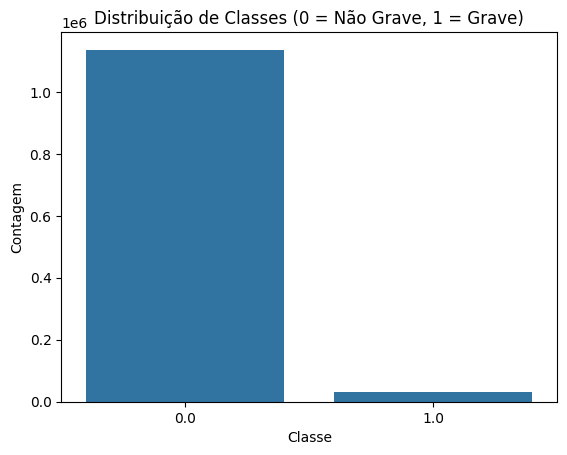

In [4]:
print("Distribuição de classes:")
class_distribution = df_dengue['RISCO_GRAVIDADE_grave'].value_counts(normalize=True) * 100
display(class_distribution)

# Visualização gráfica
sns.countplot(x=df_dengue['RISCO_GRAVIDADE_grave'])
plt.title('Distribuição de Classes (0 = Não Grave, 1 = Grave)')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.show()

A classe `1` (Risco de Gravidade) é significativamente minoritária. Um modelo treinado com estes dados tenderia a prever sempre `0`, obtendo uma alta acurácia mas sendo inútil na prática. Por isso, usaremos SMOTE.

### Preparação dos Dados para Modelagem

In [10]:
# Remove coluna de data
df_datas = df_dengue['DT_NOTIFIC']
df_dengue = df_dengue.drop('DT_NOTIFIC', axis=1)

# Definir X (features) e y (alvo)
X = df_dengue.drop('RISCO_GRAVIDADE_grave', axis=1)
y = df_dengue['RISCO_GRAVIDADE_grave']

In [11]:
# Dividir os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
    )

print("Separação de dados concluída:")
print(f"Tamanho do conjunto de treino: {X_train.shape[0]:,} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]:,} amostras")

Separação de dados concluída:
Tamanho do conjunto de treino: 932,683 amostras
Tamanho do conjunto de teste: 233,171 amostras


## Regressão Logística

### Treinamento do Modelo com Pipeline

Será utilizada um `Pipeline` da Scikit-learn para organizar o fluxo de trabalho. Isto garante que o SMOTE seja aplicado **apenas** aos dados de treino, evitando o vazamento de dados (*data leakage*)

In [12]:
pipeline_logreg = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])

print("Iniciando o treinamento do pipeline de Regressão Logística...")

# Treinar o pipeline com os dados de treino
pipeline_logreg.fit(X_train, y_train)

print("Treinamento concluído")

Iniciando o treinamento do pipeline de Regressão Logística...
Treinamento concluído


### Avaliação da Performance

Com as métricas:
 * Relatório de Classificação
 * Matriz de Confusão
 * Curva ROC e AUC

 Notando que o enfoque da avaliação será principalmente pela capacidade de detectar casos graves

--- Relatório de Classificação ---
              precision    recall  f1-score   support

         0.0       0.98      0.62      0.76    227210
         1.0       0.04      0.57      0.07      5961

    accuracy                           0.62    233171
   macro avg       0.51      0.60      0.42    233171
weighted avg       0.96      0.62      0.75    233171

--- Matriz de Confusão ---


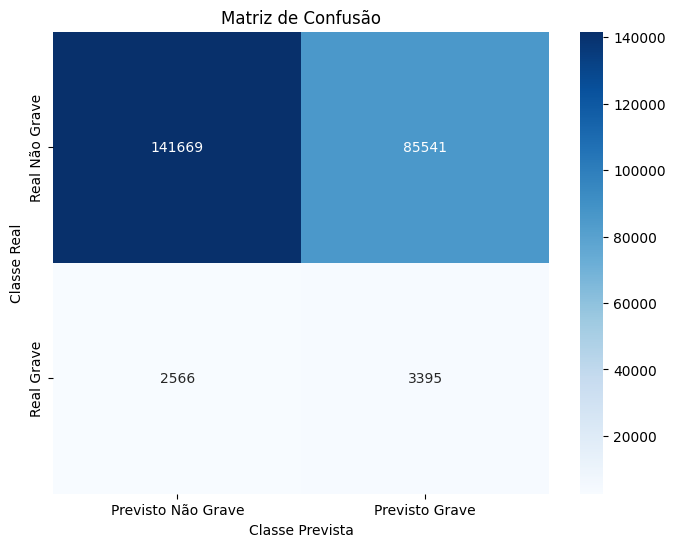

--- Curva ROC e AUC ---
Área Sob a Curva (AUC): 0.6230


<Figure size 800x600 with 0 Axes>

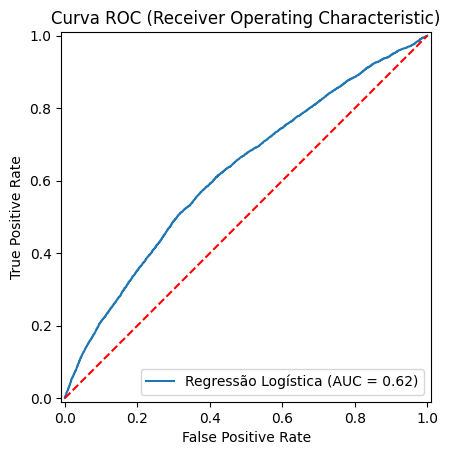

In [13]:
if 'pipeline_logreg' in locals():
    # Fazer previsões no conjunto de teste
    y_pred = pipeline_logreg.predict(X_test)
    y_proba = pipeline_logreg.predict_proba(X_test)[:, 1] # Probabilidades para a classe 1

    # --- Relatório de Classificação ---
    print("--- Relatório de Classificação ---")
    # Foco principal no 'recall' da classe 1, que indica a capacidade de detetar casos graves
    print(classification_report(y_test, y_pred))

    # --- Matriz de Confusão ---"
    print("--- Matriz de Confusão ---")
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Previsto Não Grave', 'Previsto Grave'],
                yticklabels=['Real Não Grave', 'Real Grave'])
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Prevista')
    plt.title('Matriz de Confusão')
    plt.show()

    # --- Curva ROC e AUC ---\n",
    print("--- Curva ROC e AUC ---")
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    print(f"Área Sob a Curva (AUC): {roc_auc:.4f}")

    plt.figure(figsize=(8, 6))
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Regressão Logística').plot()
    plt.title('Curva ROC (Receiver Operating Characteristic)')
    plt.plot([0, 1], [0, 1], 'r--') # Linha de referência
    plt.show()

## Random Forest

### Treinamento do Modelo com Pipeline

Pode demorar alguns minutos

In [15]:
print("Criar e treinar o pipeline Random Forest...")

pipeline_rf = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

pipeline_rf.fit(X_train, y_train)
print("Treinamento concluído.")

Criar e treinar o pipeline Random Forest...
Treinamento concluído.


### Avaliação da Performance

Com as métricas:
 * Relatório de Classificação
 * Matriz de Confusão
 * Curva ROC e AUC
 * Feature Importance

 Notando que o enfoque da avaliação será principalmente pela capacidade de detectar casos graves

 Aqui também podemos avaliar quais as características mais importantes na hora de fazer a classificação entre casos graves e não graves


--- AVALIAÇÃO DO MODELO RANDOM FOREST ---

--- Relatório de Classificação ---
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98    227210
         1.0       0.03      0.03      0.03      5961

    accuracy                           0.95    233171
   macro avg       0.50      0.50      0.50    233171
weighted avg       0.95      0.95      0.95    233171


--- Matriz de Confusão ---


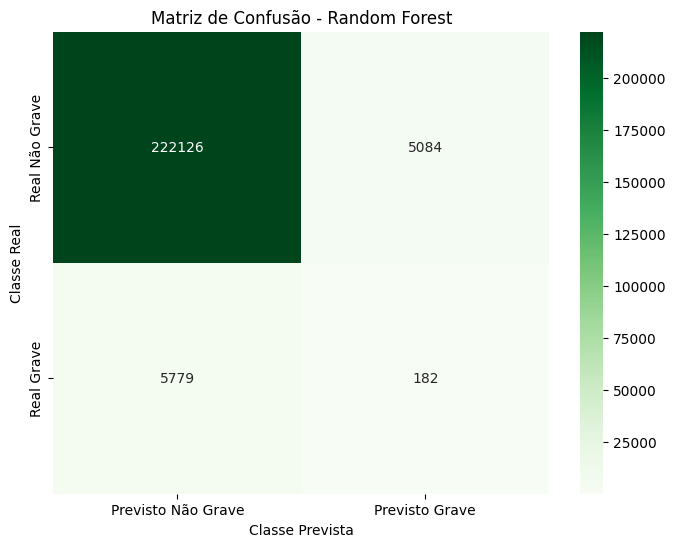


--- Curva ROC e AUC ---
Área Sob a Curva (AUC): 0.5237


<Figure size 800x600 with 0 Axes>

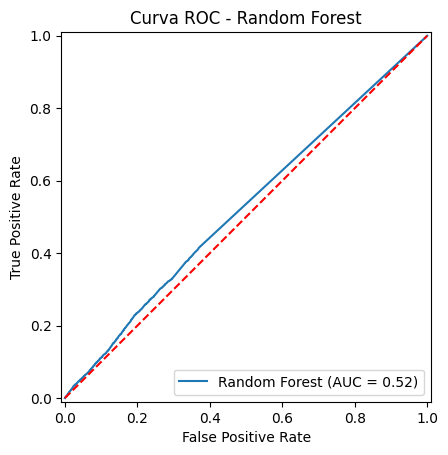


--- Importância das Features ---
              feature  importance
0          IDADE_ANOS    0.182259
1   DIAS_COM_SINTOMAS    0.122500
13         VOMITO_sim    0.089068
14         NAUSEA_sim    0.075080
2           CS_SEXO_F    0.072048
17      DOR_RETRO_sim    0.071545
11       CEFALEIA_sim    0.064029
10        MIALGIA_sim    0.054984
16      ARTRALGIA_sim    0.054818
9           FEBRE_sim    0.050149
5      CS_RACA_Branca    0.044157
12       EXANTEMA_sim    0.037416
4     CS_RACA_Amarela    0.035495
15     PETEQUIA_N_sim    0.030193
7       CS_RACA_Parda    0.012050
8       CS_RACA_Preta    0.003546
6    CS_RACA_Indigena    0.000476
3           CS_SEXO_I    0.000185


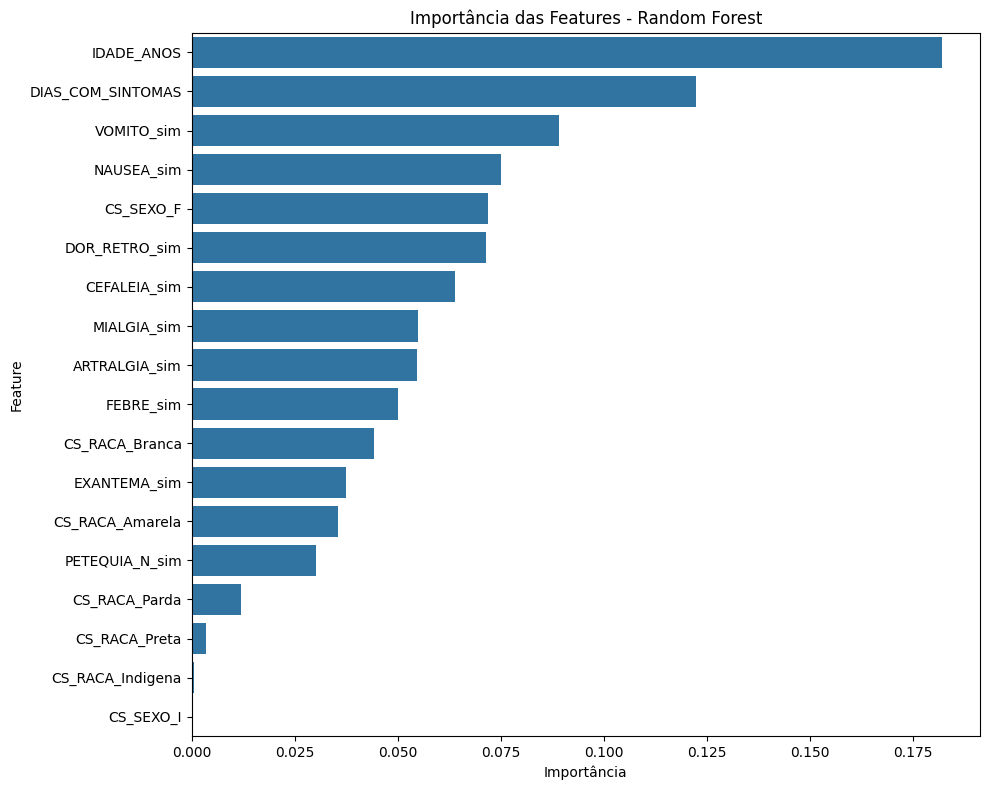

In [16]:
print("\n--- AVALIAÇÃO DO MODELO RANDOM FOREST ---")
y_pred = pipeline_rf.predict(X_test)
y_proba = pipeline_rf.predict_proba(X_test)[:, 1]

# Relatório de Classificação
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Previsto Não Grave', 'Previsto Grave'],
            yticklabels=['Real Não Grave', 'Real Grave'])
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

# Curva ROC e AUC
print("\n--- Curva ROC e AUC ---")
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"Área Sob a Curva (AUC): {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest').plot()
plt.title('Curva ROC - Random Forest')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

# --- Análise de Importância das Features ---
print("\n--- Importância das Features ---")
# Acessar o modelo treinado dentro do pipeline
rf_model = pipeline_rf.named_steps['classifier']
importances = rf_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Importância das Features - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## XGBoost

### Treinamento do Modelo com Pipeline

In [18]:
print("Criar e treinar o pipeline Random Forest...")
pipeline_xgb = ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('scaler', StandardScaler()),
            ('classifier', xgb.XGBClassifier(
                random_state=42,
                eval_metric='logloss',
                n_jobs=-1
            ))
        ])

pipeline_xgb.fit(X_train, y_train)
print("Treinamento concluído.")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:02:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Treinamento concluído.


### Avaliação da Performance

Com as métricas:
 * Relatório de Classificação
 * Matriz de Confusão
 * Curva ROC e AUC
 * Feature Importance

 Notando que o enfoque da avaliação será principalmente pela capacidade de detectar casos graves

 Aqui também podemos avaliar quais as características mais importantes na hora de fazer a classificação entre casos graves e não graves


--- AVALIAÇÃO DO MODELO XGBOOST ---

--- Relatório de Classificação ---
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99    227210
         1.0       0.05      0.00      0.01      5961

    accuracy                           0.97    233171
   macro avg       0.51      0.50      0.50    233171
weighted avg       0.95      0.97      0.96    233171


--- Matriz de Confusão ---


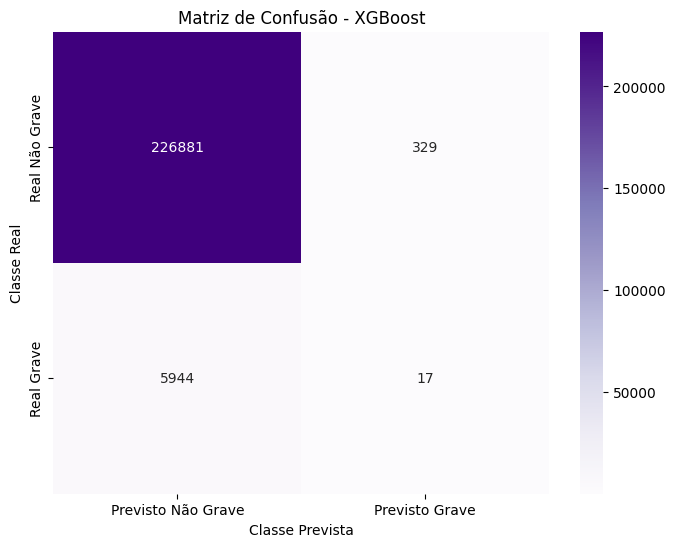


--- Curva ROC e AUC ---
Área Sob a Curva (AUC): 0.5519


<Figure size 800x600 with 0 Axes>

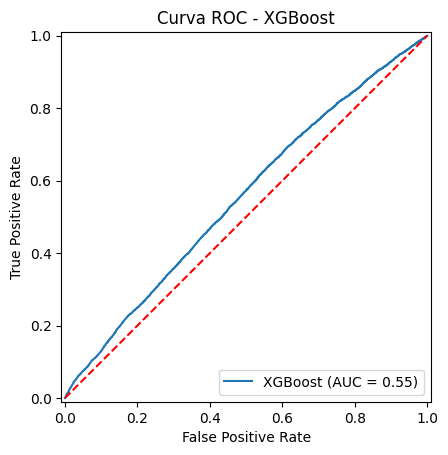


--- Importância das Features ---
              feature  importance
2           CS_SEXO_F    0.093336
16      ARTRALGIA_sim    0.082450
9           FEBRE_sim    0.079285
10        MIALGIA_sim    0.078966
11       CEFALEIA_sim    0.075567
12       EXANTEMA_sim    0.075224
17      DOR_RETRO_sim    0.074841
13         VOMITO_sim    0.074025
5      CS_RACA_Branca    0.067743
15     PETEQUIA_N_sim    0.064411
4     CS_RACA_Amarela    0.062445
14         NAUSEA_sim    0.060946
7       CS_RACA_Parda    0.040125
1   DIAS_COM_SINTOMAS    0.036686
8       CS_RACA_Preta    0.020626
0          IDADE_ANOS    0.007436
6    CS_RACA_Indigena    0.003119
3           CS_SEXO_I    0.002769


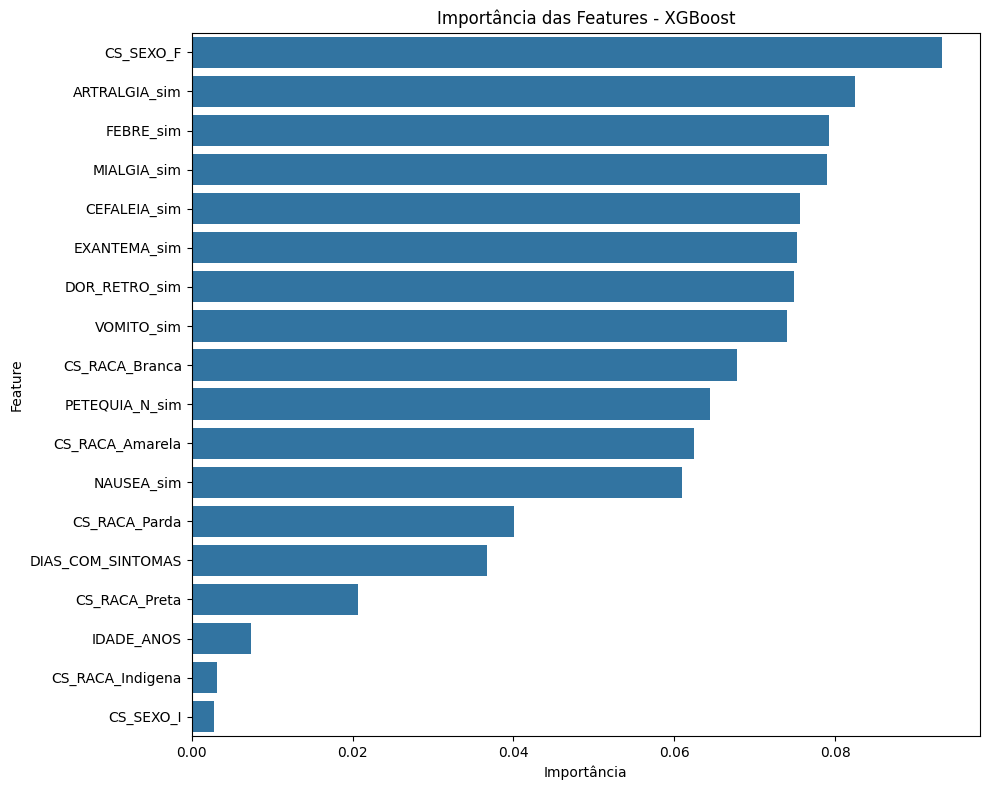

In [19]:
print("\n--- AVALIAÇÃO DO MODELO XGBOOST ---")
y_pred = pipeline_xgb.predict(X_test)
y_proba = pipeline_xgb.predict_proba(X_test)[:, 1]

# 1. Relatório de Classificação
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred))

# 2. Matriz de Confusão
print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Previsto Não Grave', 'Previsto Grave'],
            yticklabels=['Real Não Grave', 'Real Grave'])
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.title('Matriz de Confusão - XGBoost')
plt.show()

# 3. Curva ROC e AUC
print("\n--- Curva ROC e AUC ---")
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"Área Sob a Curva (AUC): {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBoost').plot()
plt.title('Curva ROC - XGBoost')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

# --- Análise de Importância das Features ---
print("\n--- Importância das Features ---")
xgb_model = pipeline_xgb.named_steps['classifier']
importances = xgb_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Importância das Features - XGBoost')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

OS MODELOS ESTÃO MUITO RUINS, USAR MÉTODOS DE AJUSTAR OS HIPERPARÂMETROS E OS FOLDS